# CatBoost

## Навигация

- [Оптимизация гиперпараметров с кросс-валидацией](#Оптимизация-гиперпараметров-с-кросс-валидацией)
- [Refit на всём X_train](#Refit-на-всём-X_train)
- [Perfomance на X_test](#Perfomance-на-X_test)
- [Perfomance на X_train](#Perfomance-на-X_train)
- [SHAP values](#SHAP-values)
- [Permutation Importance](#Permutation-Importance)

In [1]:
import os
import sys
sys.path.append('..')
from typing import Dict

import catboost
import optuna
import pandas as pd
import shap

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance

from my_ds_tools.classification import my_multiclass_classification_report
from my_ds_tools.interpretation import permutation_importance_plot
import src

In [2]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [3]:
TRAIN_DATA_PATH = os.path.join('..', 'data', 'processed', 'train_data.csv')
TEST_DATA_PATH = os.path.join('..', 'data', 'processed', 'test_data.csv')

N_TRIALS = 25

CAT_FEATURES = sorted(list(src.constants.CATEGORICAL_FEATURES))
FEATURES_TO_IMPUT = [src.constants.QUESTION_2]
USEFUL_FOR_IMPUT = [
    src.constants.QUESTION_6, src.constants.QUESTION_8, src.constants.QUESTION_31,
    src.constants.QUESTION_32, src.constants.QUESTION_33, src.constants.QUESTION_34,
    src.constants.QUESTION_35,
]

In [4]:
train_data = pd.read_csv(TRAIN_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)

X_train = train_data.drop(columns=src.constants.TARGET)
X_test = test_data.drop(columns=src.constants.TARGET)
y_train = train_data[src.constants.TARGET]
y_test = test_data[src.constants.TARGET]

## Оптимизация гиперпараметров с кросс-валидацией

[К навигации](#Навигация)

In [5]:
def objective(trial: optuna.trial.Trial) -> float:
    """Целевая функция для оптимизации гиперпараметров."""
    model = get_model(trial, mode='fit')

    scores = cross_val_score(
        estimator=model,
        X=X_train,
        y=y_train,
        scoring='accuracy',
        cv=LeaveOneOut(),
        n_jobs=-1,
    )

    return scores.mean()


def get_model(trial: optuna.trial.Trial, mode: str) -> sklearn.pipeline.Pipeline:

    constant_imputer = SimpleImputer(strategy='constant', fill_value='пропуск')

    preprocessing = ColumnTransformer(
        transformers=[
            ('knn_imputer', KNNImputer(), FEATURES_TO_IMPUT + USEFUL_FOR_IMPUT),
            ('constant_imputer', constant_imputer, CAT_FEATURES),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False,
    ).set_output(transform='pandas')

    catboost_model = catboost.CatBoostClassifier(**get_init_hyperparams(trial, mode))

    pipe = Pipeline([
        ('preprocessing', preprocessing),
        ('catboost', catboost_model),
    ])

    return pipe


def get_init_hyperparams(trial: optuna.trial.Trial, mode: str) -> Dict:

    match mode:
        case 'fit':
            max_depth = trial.suggest_int('max_depth', 1, 5)
            max_leaves = trial.suggest_int('max_leaves', 2, 16)
            min_data_in_leaf = trial.suggest_float('min_data_in_leaf', .04, .2)
        case 'refit':
            max_depth = trial.params['max_depth']
            max_leaves = trial.params['max_leaves']
            min_data_in_leaf = trial.params['min_data_in_leaf']
        case _:
            assert False, 'ABOBA'

    init_hyperparams = dict(
        grow_policy='Lossguide',
        n_estimators=25,
        learning_rate=.05,
        max_depth=max_depth,
        max_leaves=max_leaves,
        min_data_in_leaf=min_data_in_leaf,
        cat_features=CAT_FEATURES,
        verbose=0,
        random_state=src.constants.RANDOM_STATE,
    )

    return init_hyperparams

In [6]:
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(seed=src.constants.RANDOM_STATE),
    direction='maximize',
    study_name='catboost',
)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

  0%|          | 0/25 [00:00<?, ?it/s]

In [7]:
print('Лучшие гиперпараметры:')
for hyperparam, value in study.best_trial.params.items():
    print(f'* {hyperparam}: {value}')
print(f'Лучший mean Accuracy: {study.best_trial.value}')

Лучшие гиперпараметры:
* max_depth: 5
* max_leaves: 15
* min_data_in_leaf: 0.10966755590229849
Лучший mean Accuracy: 0.6141414141414141


## Refit на всём X_train

[К навигации](#Навигация)

In [8]:
model = get_model(study.best_trial, mode='refit')
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('knn_imputer', KNNImputer(),
                                                  ['2. Возраст',
                                                   '6. Жив ли хотя бы один из '
                                                   'Ваших родителей (да/нет)?',
                                                   '8. Есть ли у Вас дети '
                                                   '(да/нет)?',
                                                   '31. Количество родов',
                                                   '32. Количество прерванных '
                                                   'беременностей',
                                                   '33. Гинекологические '
                                                   'заболевания (да/нет)',
                                                   '34. Заболевания щитовидной '
                                                   'железы (да/нет)',
                                                   '35. Наследственность '
                                                   '(да/нет)']),
                                                 ('constant_imputer',
                                                  SimpleImputer(fill_value='пропуск',
                                                                strategy='constant'),
                                                  ['23. Каков тип Вашего дома?',
                                                   '25. Каким транспортом Вы '
                                                   'обычно пользуетесь?',
                                                   '3. Семейное положение'])],
                                   verbose_feature_names_out=False)),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x00000219CAA0A690>)])

## Perfomance на X_train

[К навигации](#Навигация)

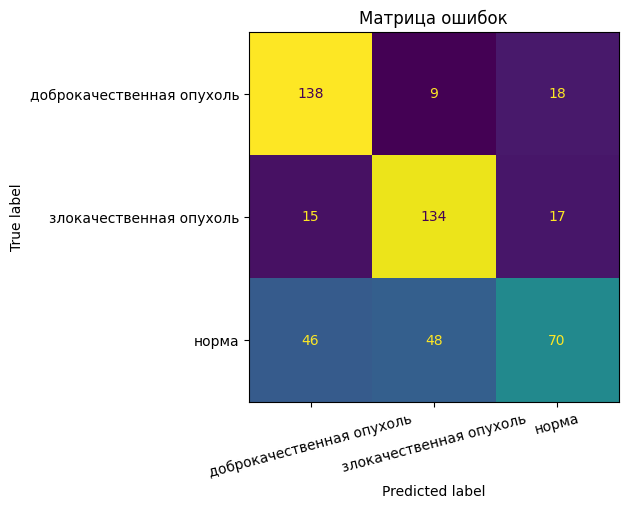

                           precision    recall  f1-score   support

доброкачественная опухоль       0.69      0.84      0.76       165
  злокачественная опухоль       0.70      0.81      0.75       166
                    норма       0.67      0.43      0.52       164

                 accuracy                           0.69       495
                macro avg       0.69      0.69      0.68       495
             weighted avg       0.69      0.69      0.68       495



In [10]:
my_multiclass_classification_report(
    model, X_train, y_train, cm_kw=dict(xticks_rotation=15))

## Perfomance на X_test

[К навигации](#Навигация)

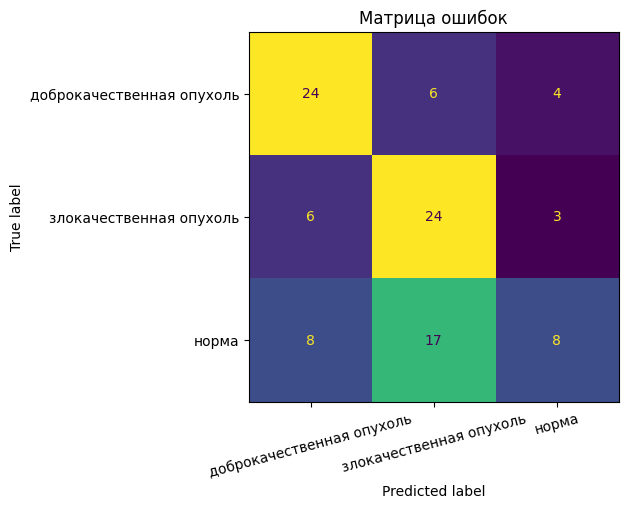

                           precision    recall  f1-score   support

доброкачественная опухоль       0.63      0.71      0.67        34
  злокачественная опухоль       0.51      0.73      0.60        33
                    норма       0.53      0.24      0.33        33

                 accuracy                           0.56       100
                macro avg       0.56      0.56      0.53       100
             weighted avg       0.56      0.56      0.53       100



In [11]:
my_multiclass_classification_report(
    model, X_test, y_test, cm_kw=dict(xticks_rotation=15))

## SHAP values

[К навигации](#Навигация)

In [12]:
catboost_model = model.named_steps['catboost']
preprocessing = model.named_steps['preprocessing']

In [13]:
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(preprocessing.transform(X_train))

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


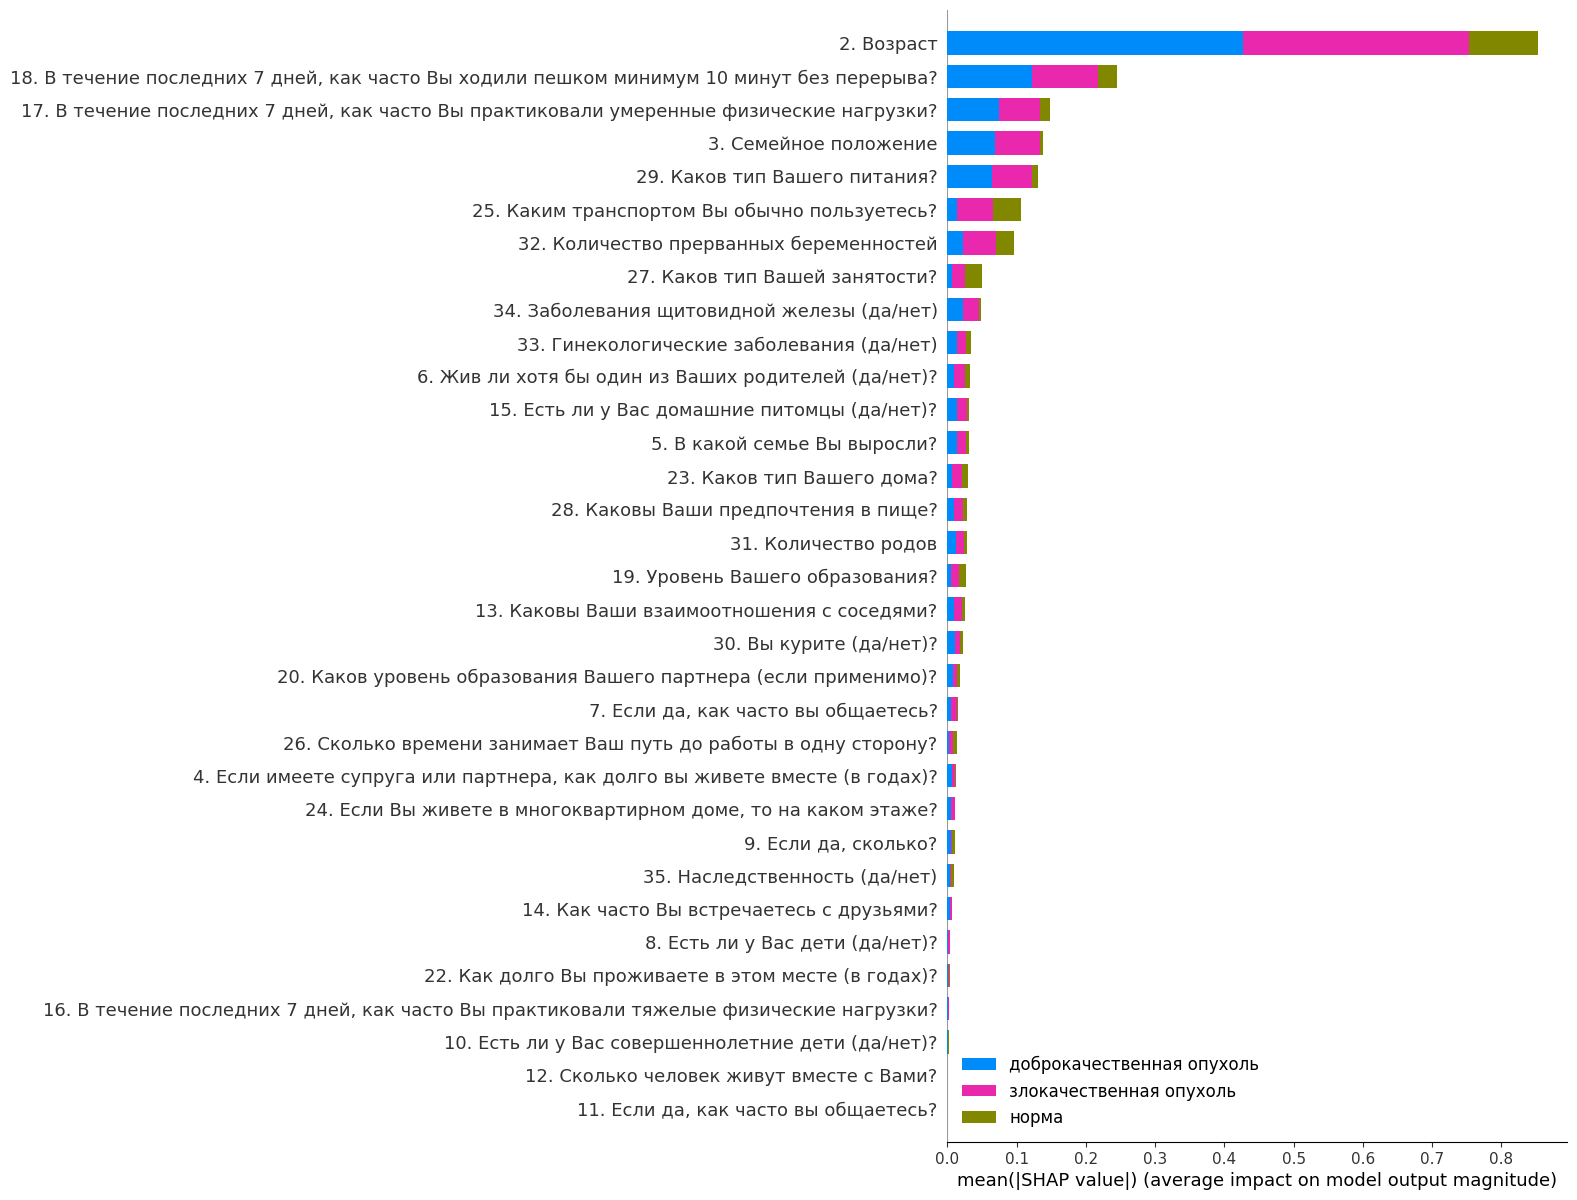

In [14]:
shap.summary_plot(
    shap_values=shap_values,
    features=X_train,
    class_names=['доброкачественная опухоль', 'злокачественная опухоль', 'норма'],
    max_display=33,
)

## Permutation Importance

[К навигации](#Навигация)

In [15]:
pi = permutation_importance(
    estimator=model,
    X=X_train,
    y=y_train,
    scoring='accuracy',
    n_repeats=1000,
    n_jobs=-1,
    random_state=src.constants.RANDOM_STATE,
)

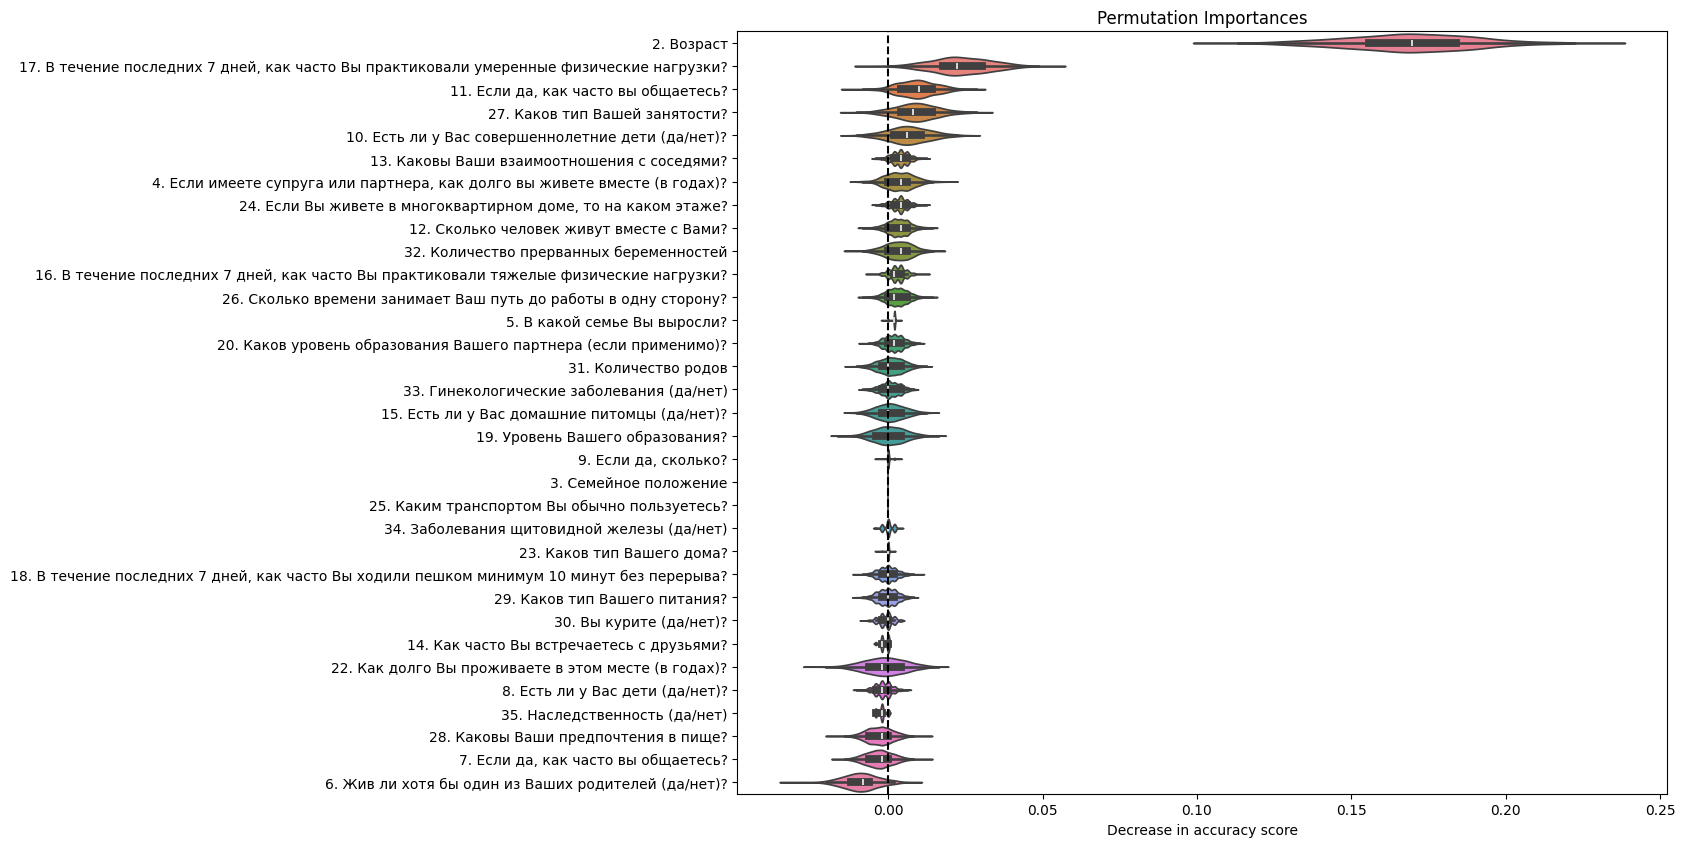

In [16]:
fig, ax = permutation_importance_plot(pi, X_train.columns)